In [1]:
import numpy as np
import matplotlib.pyplot as plt

import pickle
import os
from ANEMO import read_edf
from ANEMO import ANEMO

from scipy import stats
import scipy as sp

%matplotlib inline

In [2]:
sujet = ['AM','BMC','CS','DC','FM','IP','LB','OP','RS','SR','TN','YK']
time = ['2017-10-23_100057','2017-09-26_095637', '2017-10-03_134421','2017-09-27_161040',
        '2017-10-03_143803','2017-09-28_115250', '2017-09-20_151043','2017-10-26_121823',
        '2017-11-08_094717','2017-11-16_153313', '2017-11-08_150410','2017-11-17_172706']

In [3]:
file = os.path.join('parametre', 'Delete_list_trials_velocity_fct.pkl')
with open(file, 'rb') as fichier :
    Delete_list_trials = pickle.load(fichier, encoding='latin1')

file = os.path.join('parametre', 'Delete_list_Bad_trials_velocity.pkl')
#file = os.path.join('parametre', 'Delete_list_Bad_trials_position.pkl')
with open(file, 'rb') as fichier :
    Bad_Fit = pickle.load(fichier, encoding='latin1')

sujet[x] OP


/usr/local/lib/python3.5/dist-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


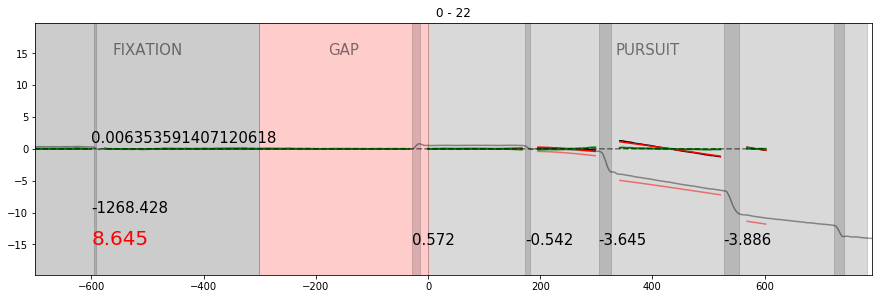

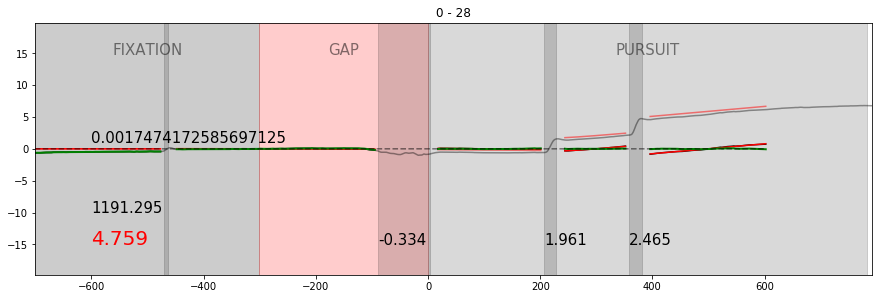

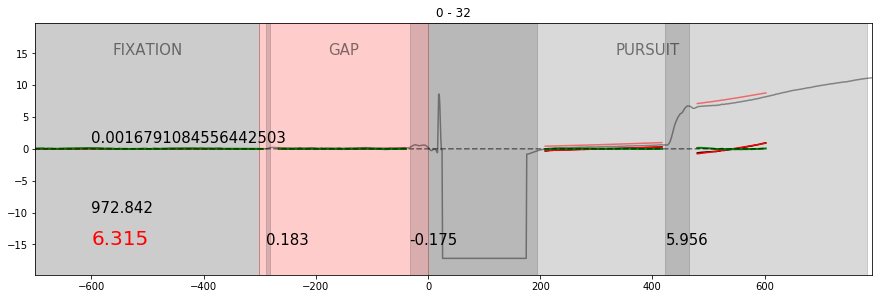

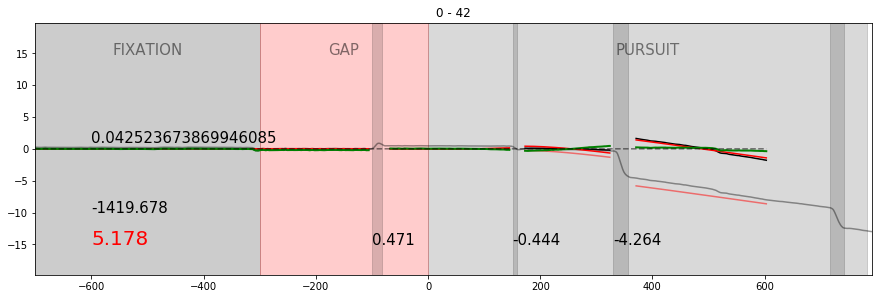

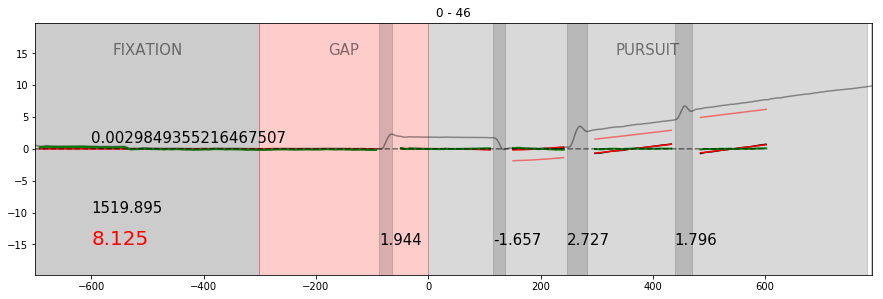

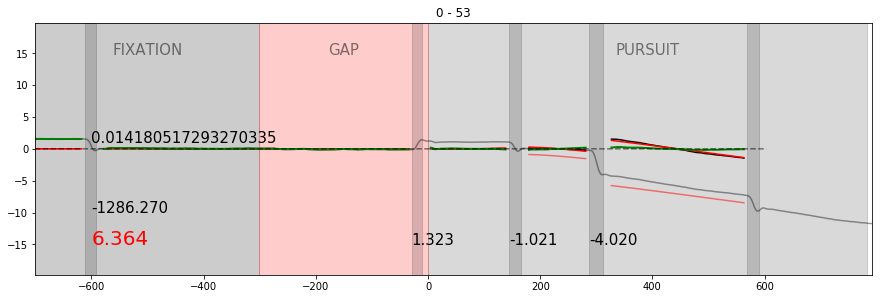

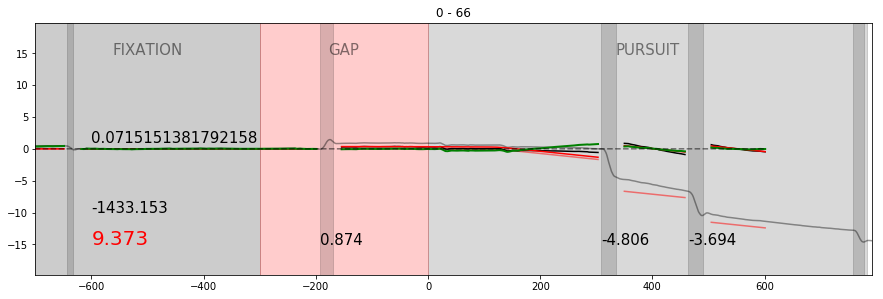

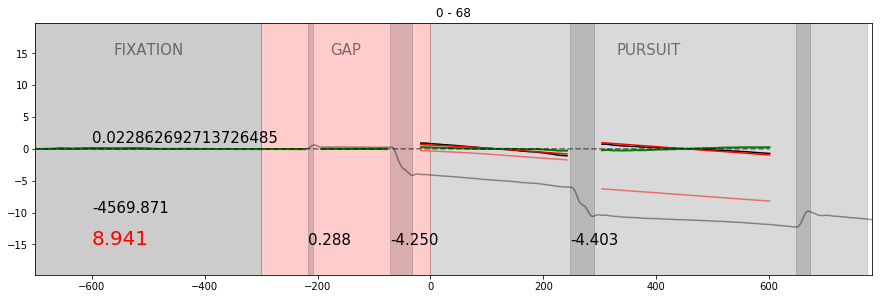

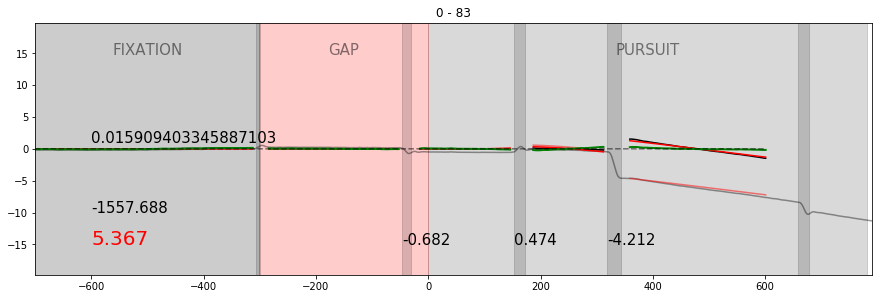

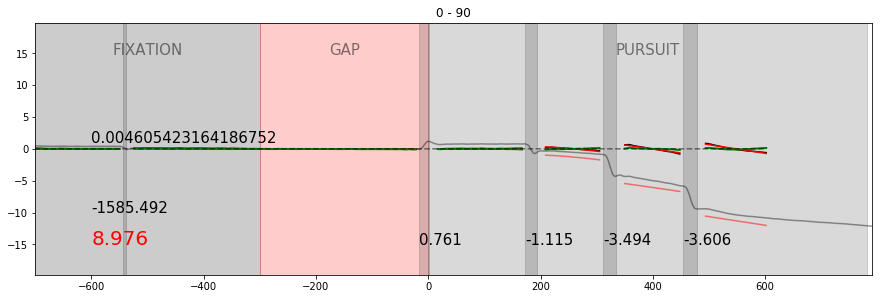

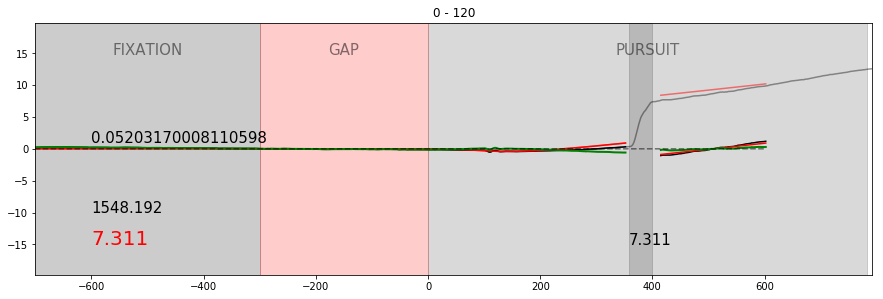

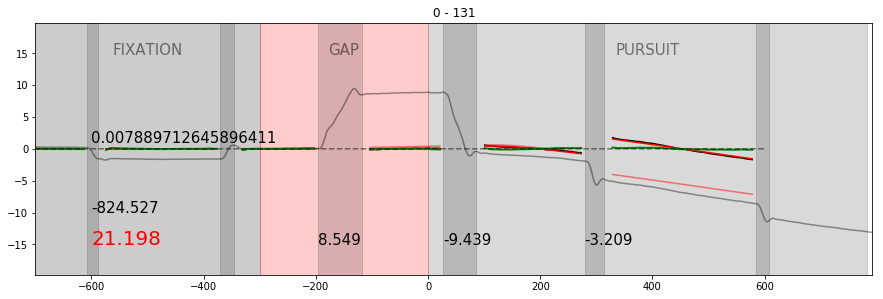

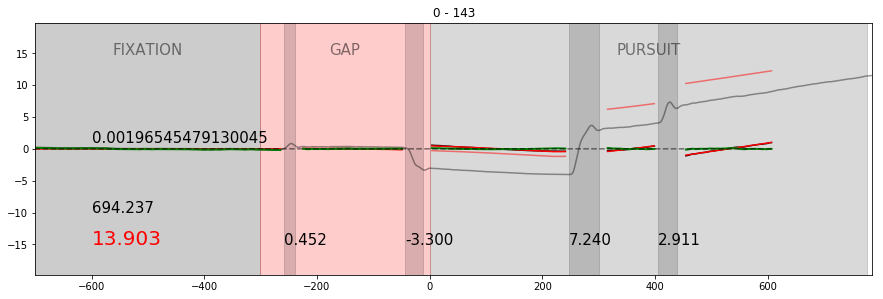

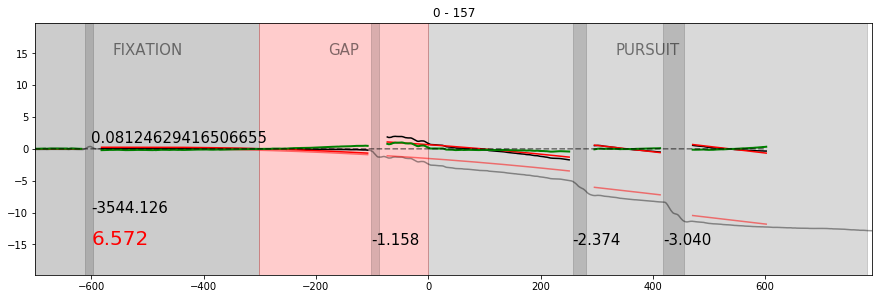

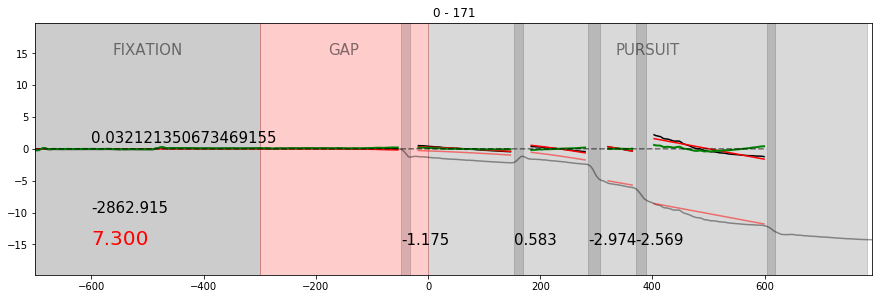

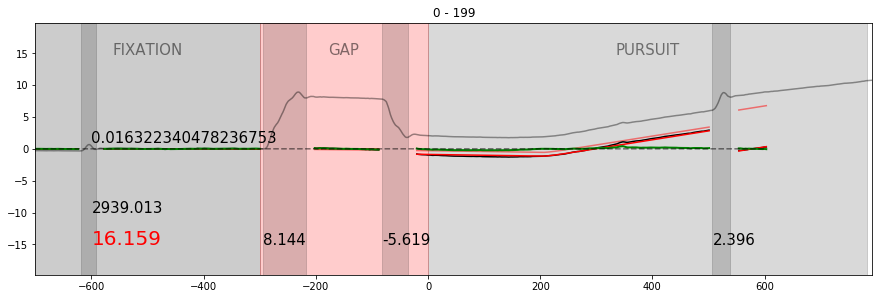

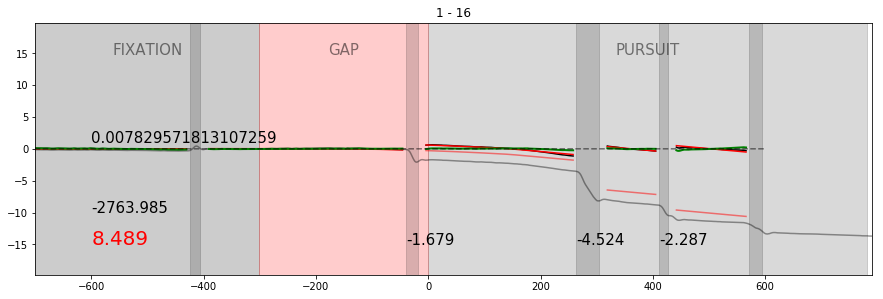

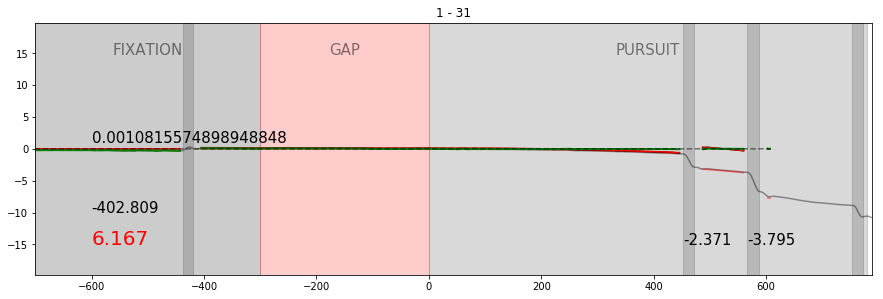

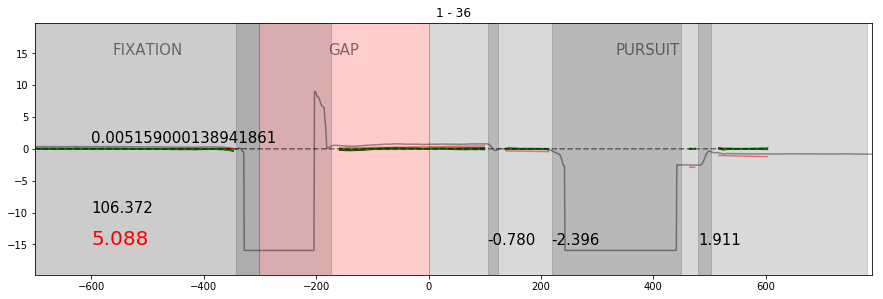

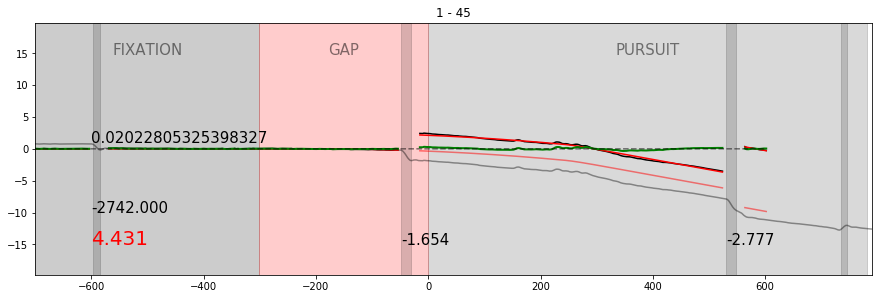

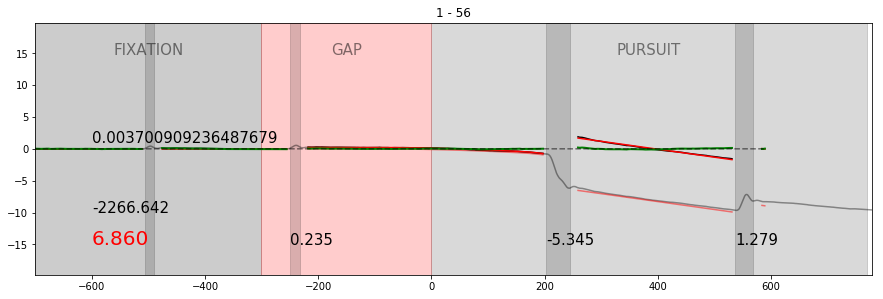

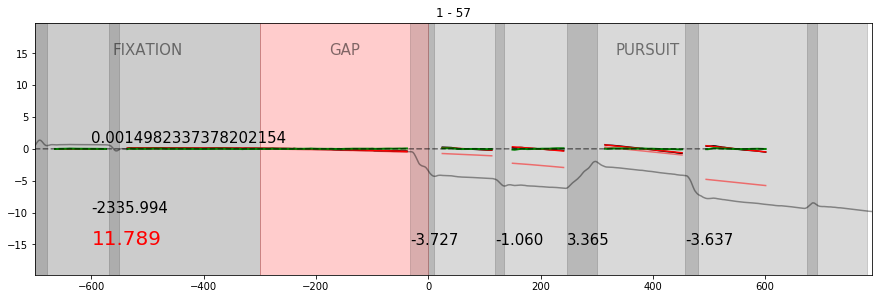

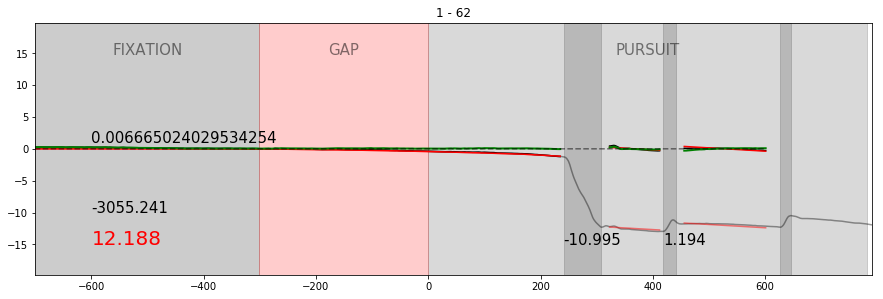

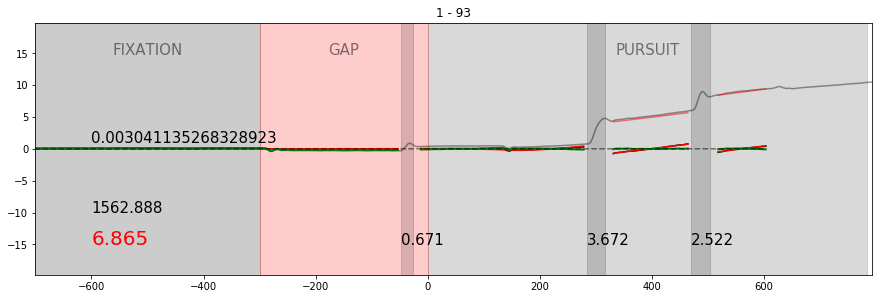

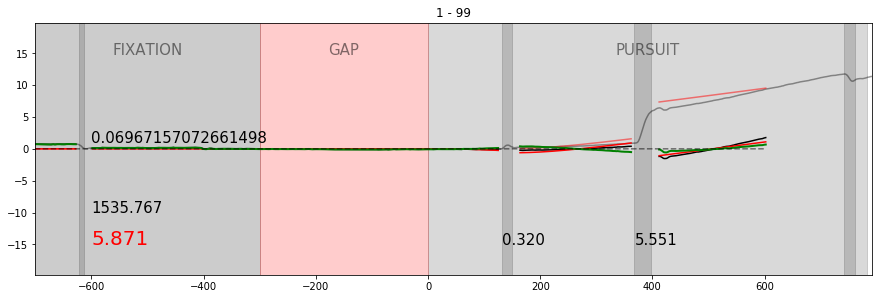

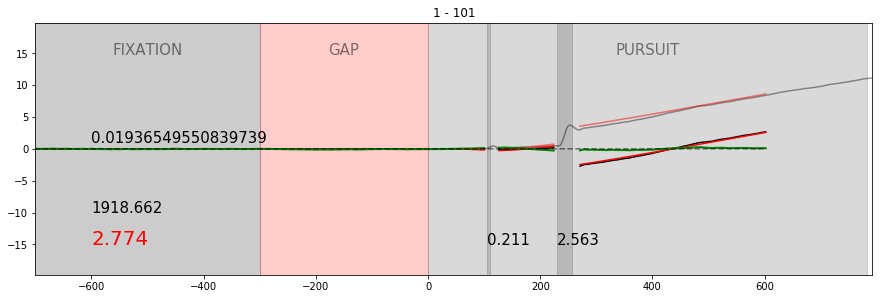

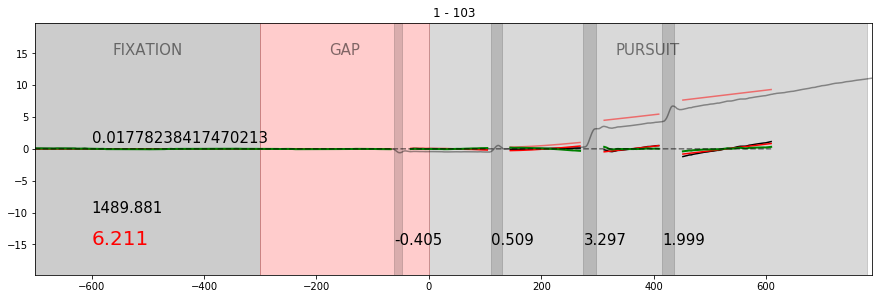

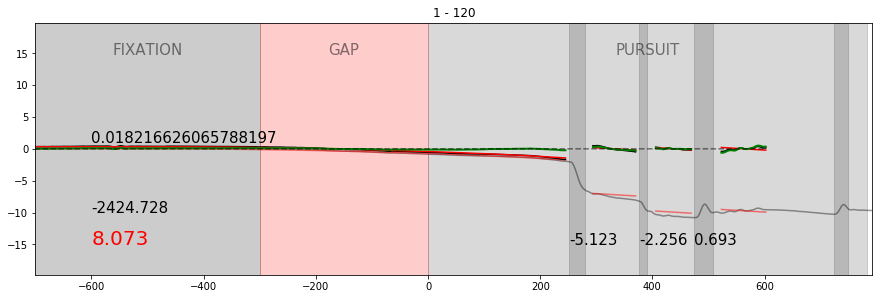

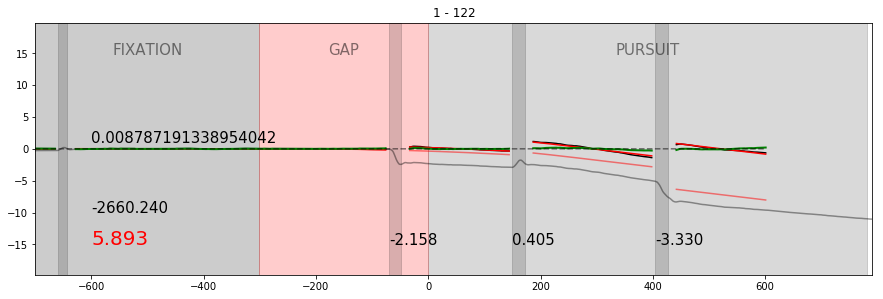

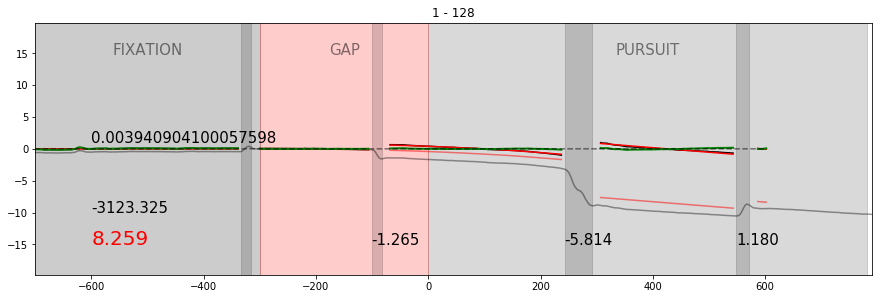

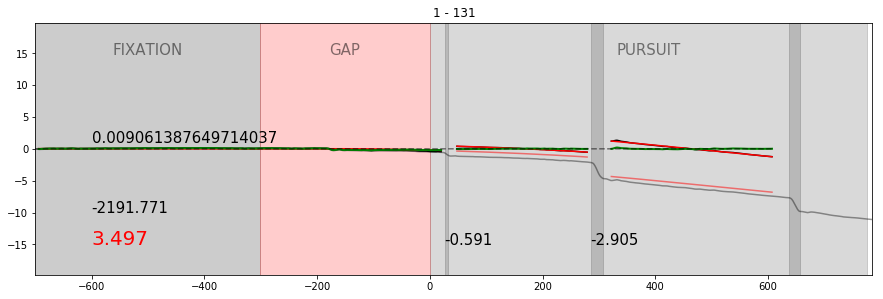

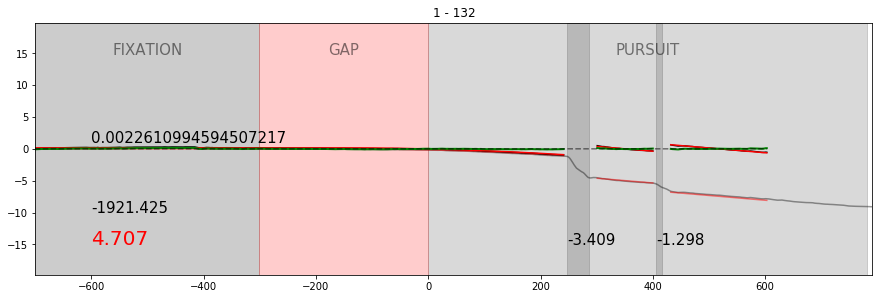

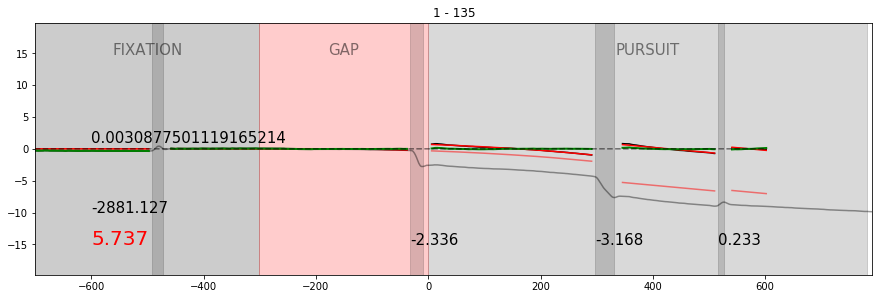

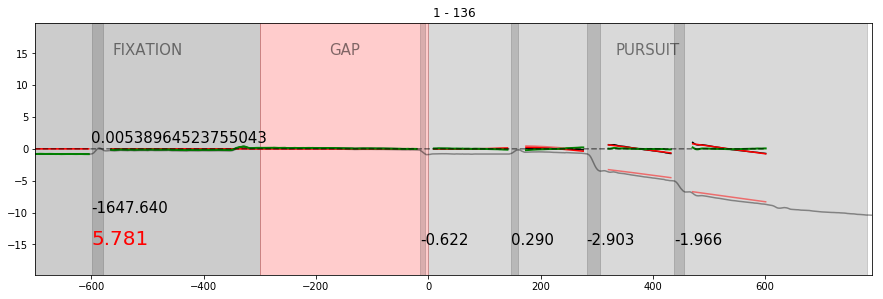

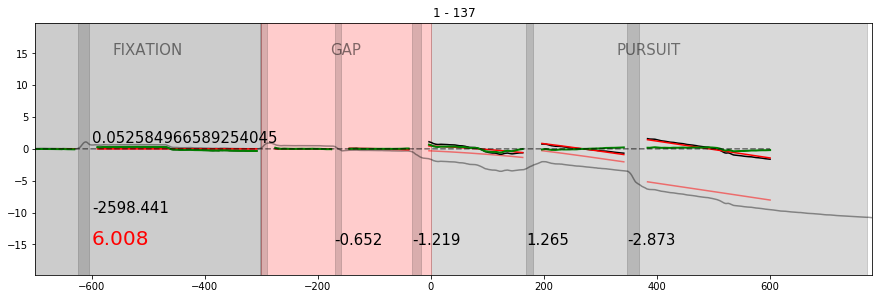

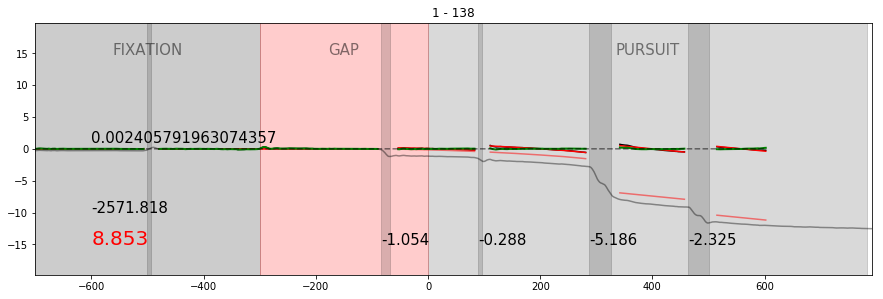

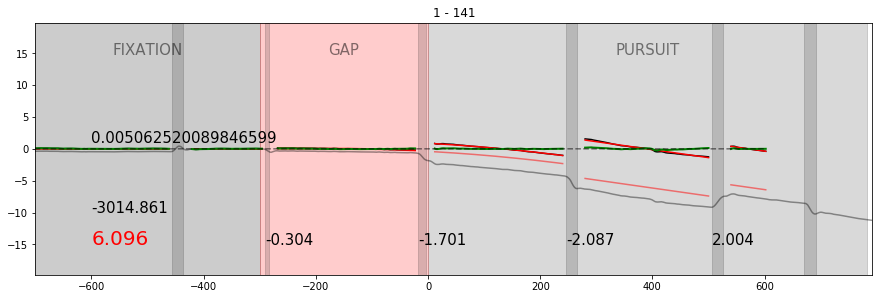

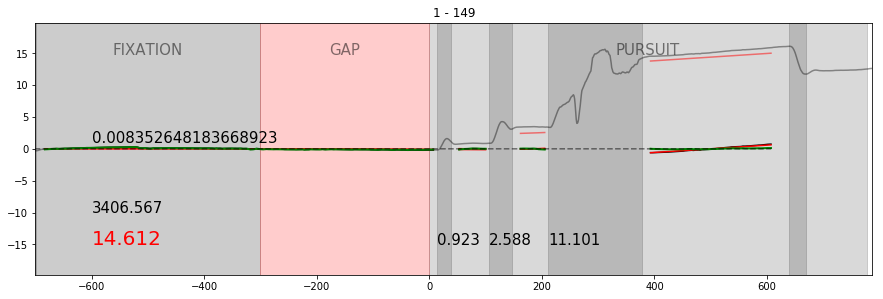

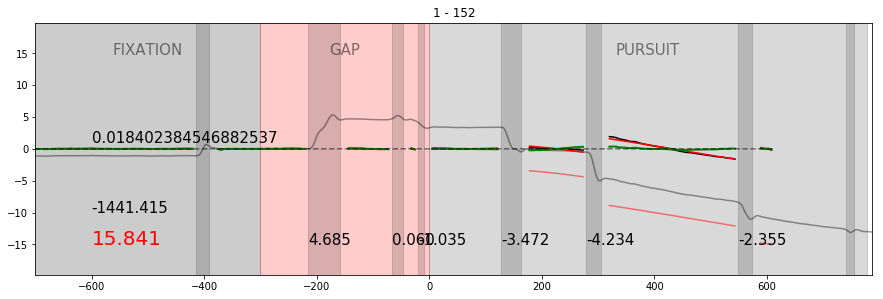

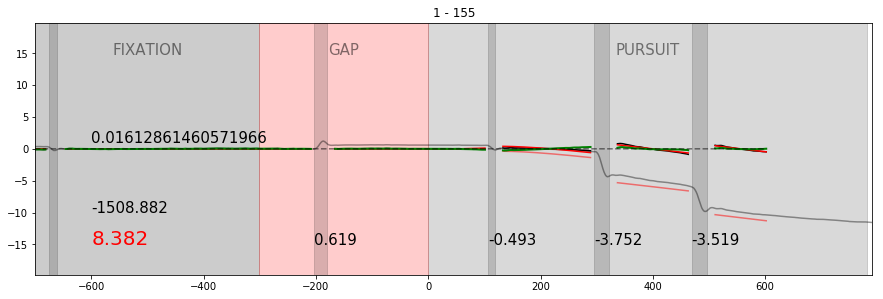

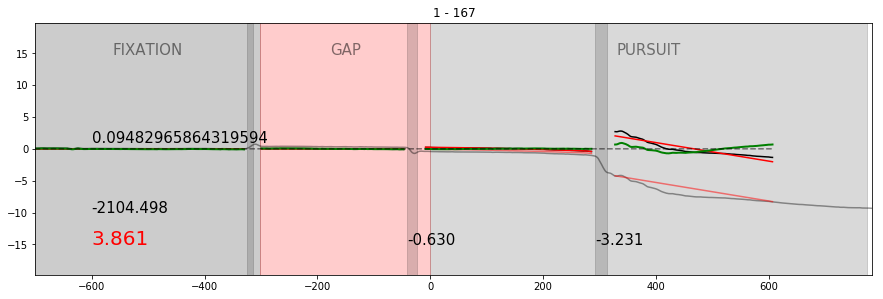

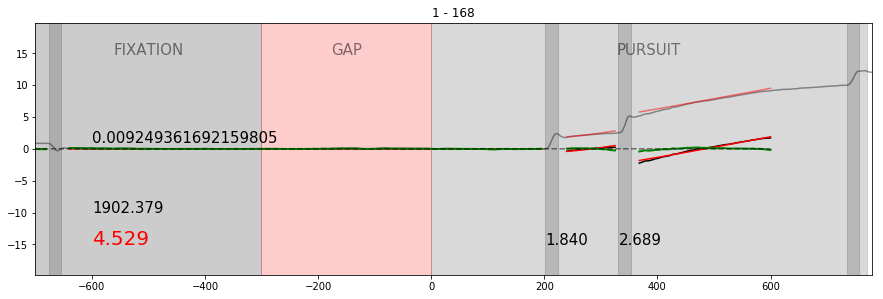

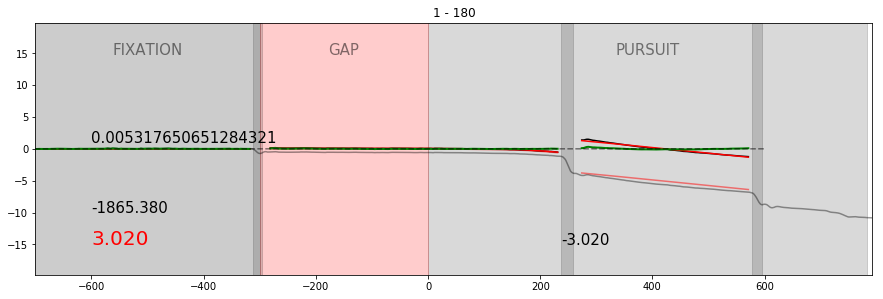

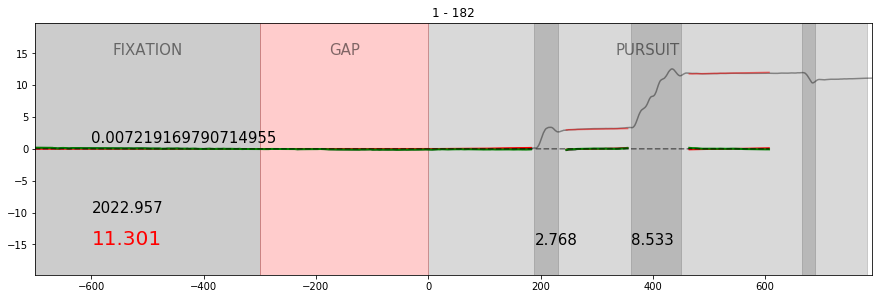

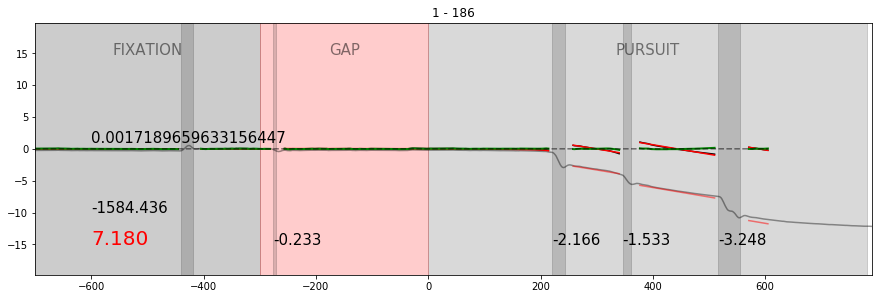

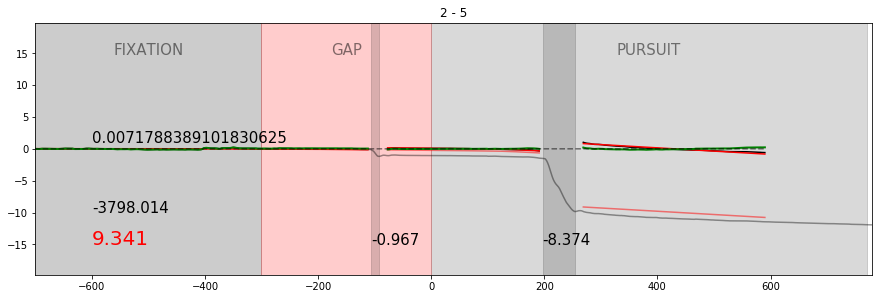

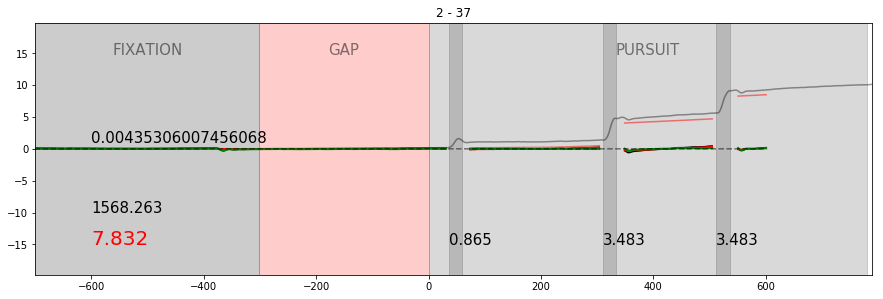

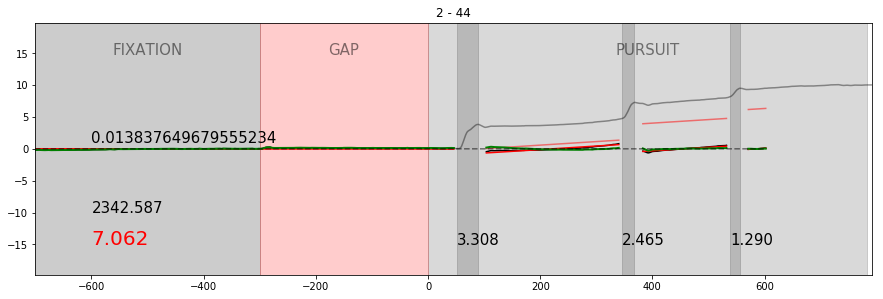

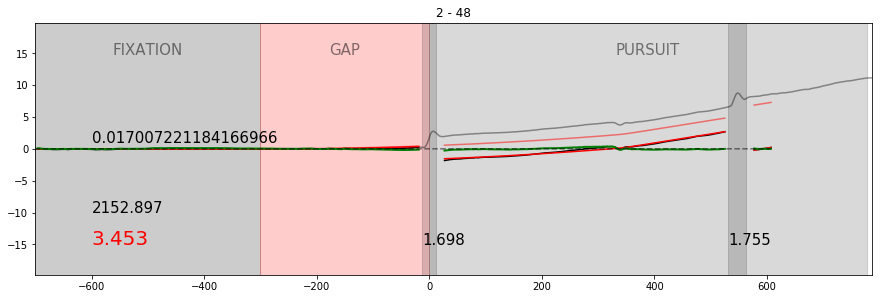

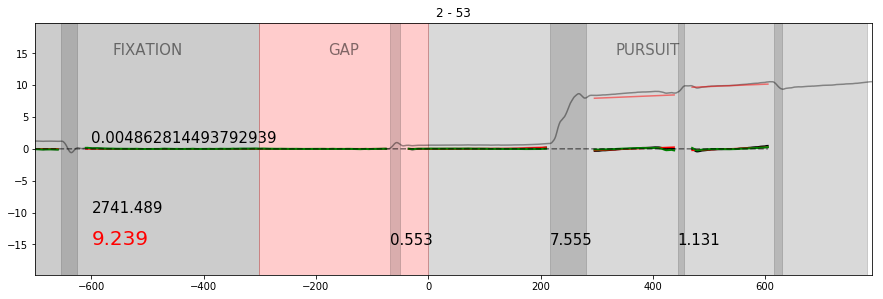

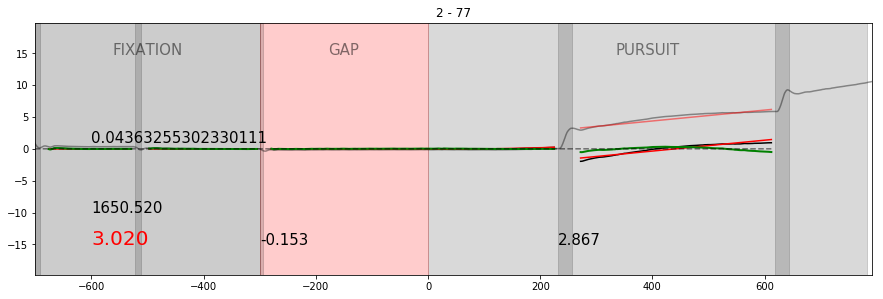

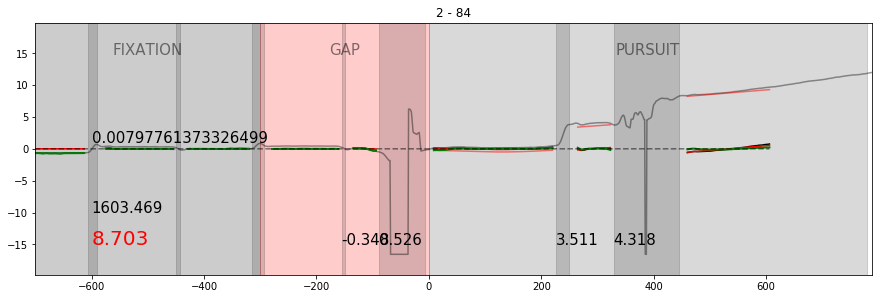

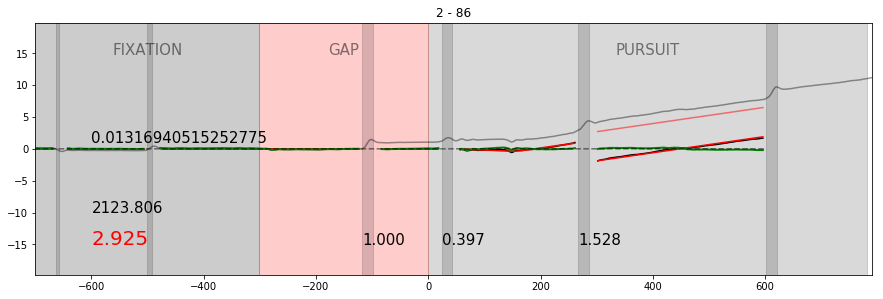

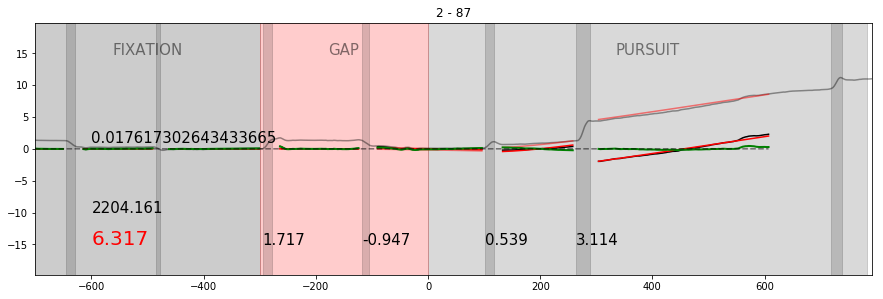

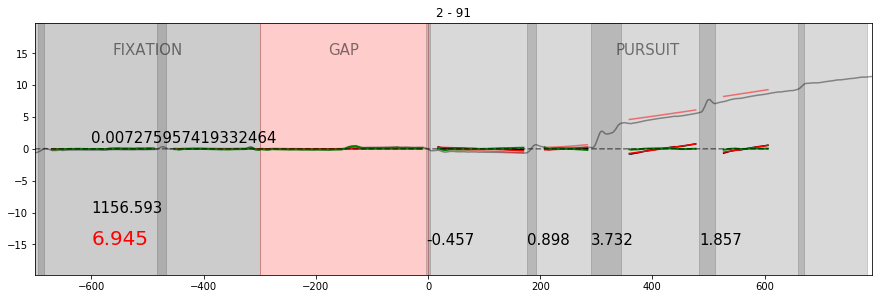

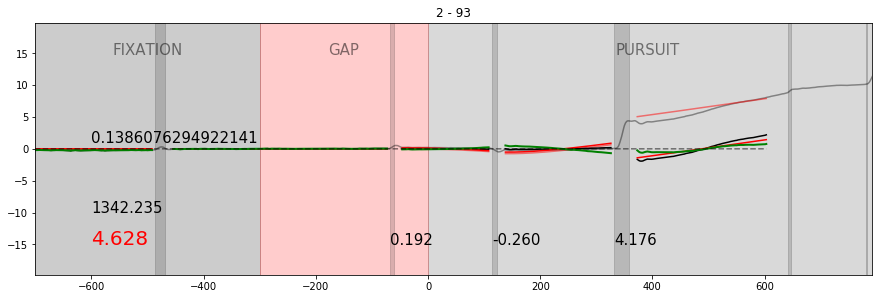

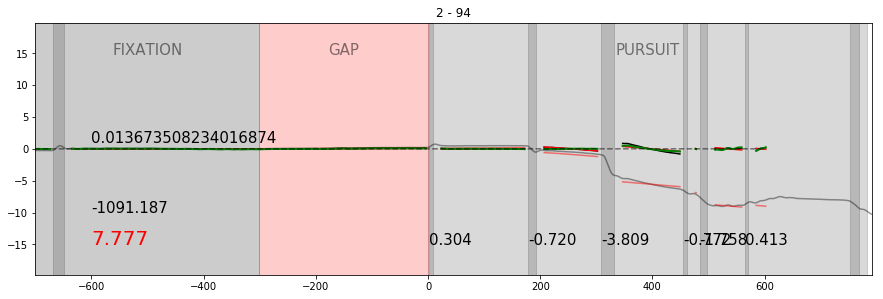

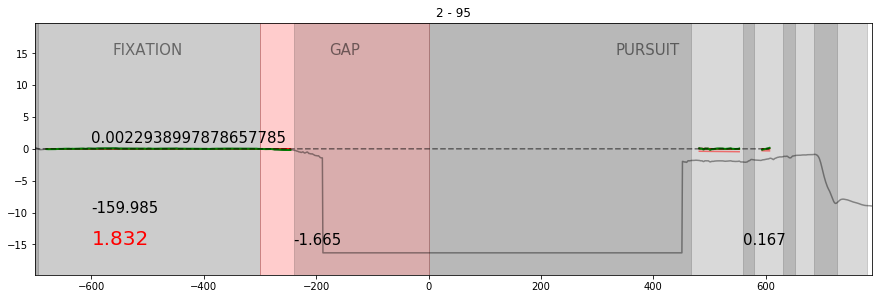

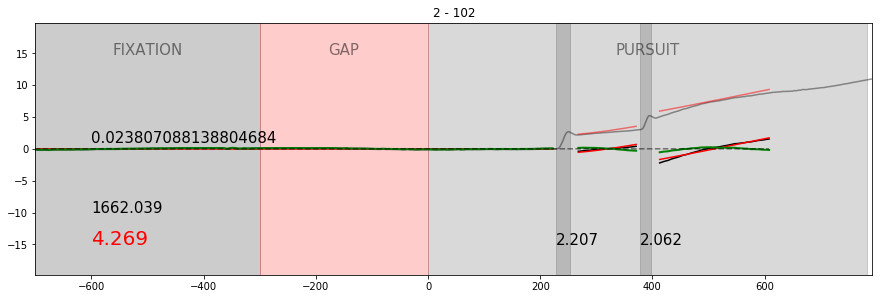

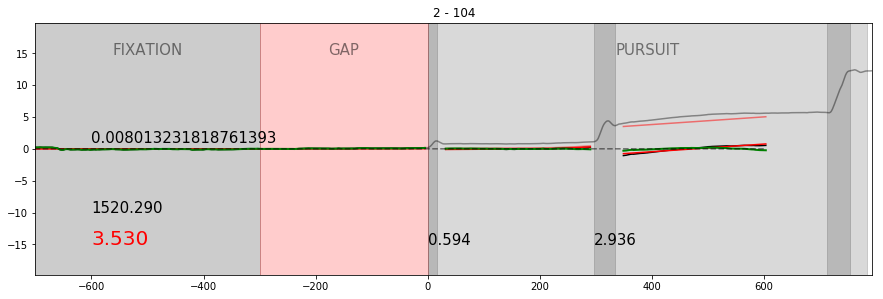

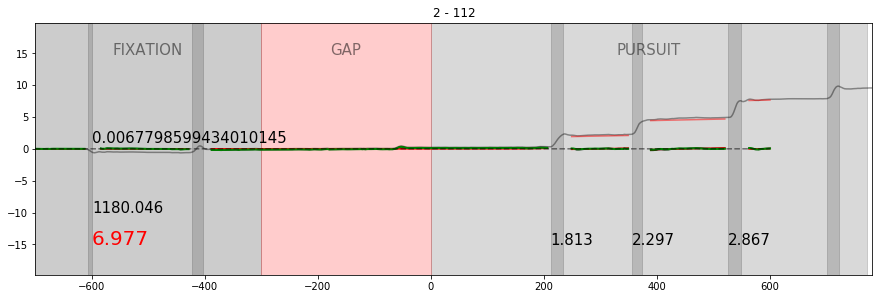

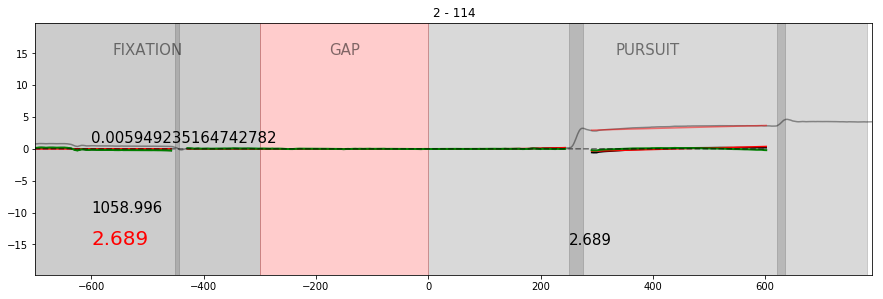

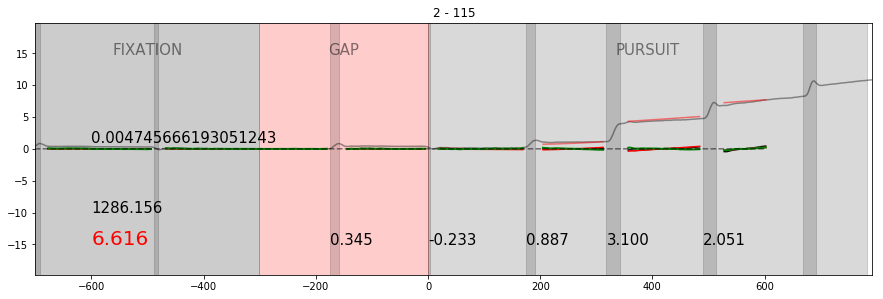

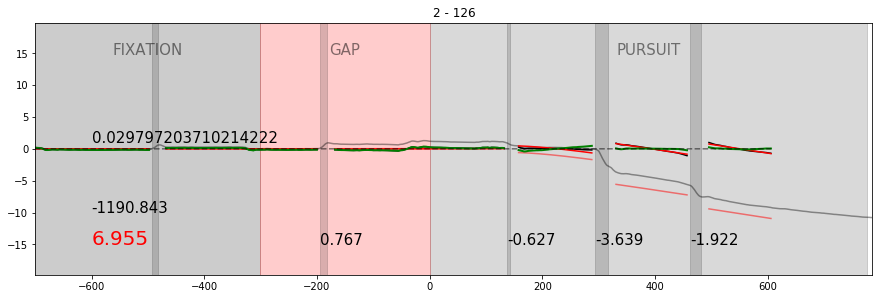

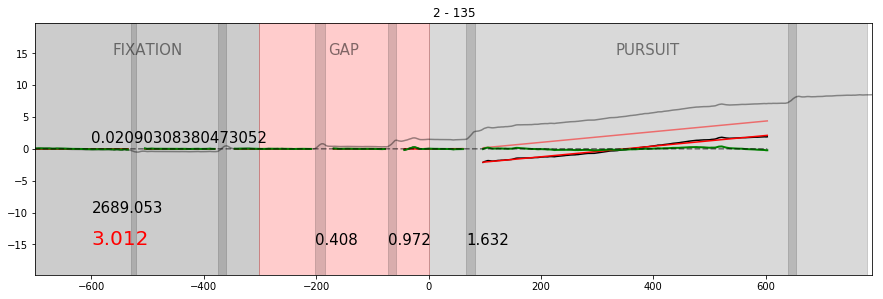

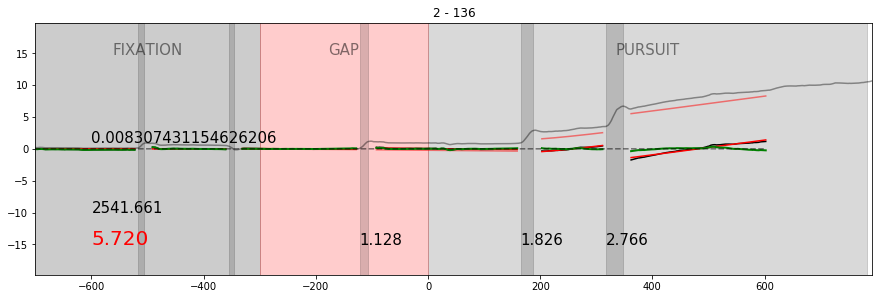

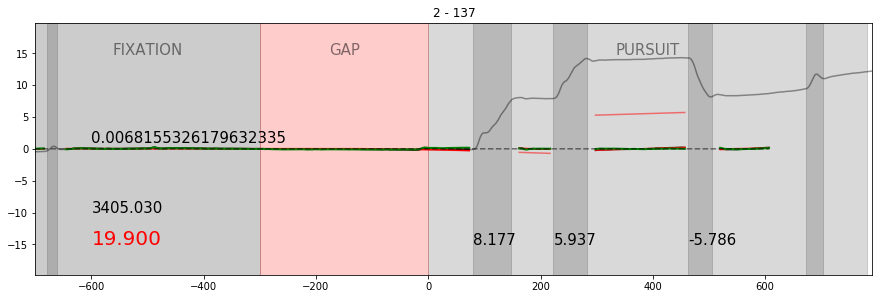

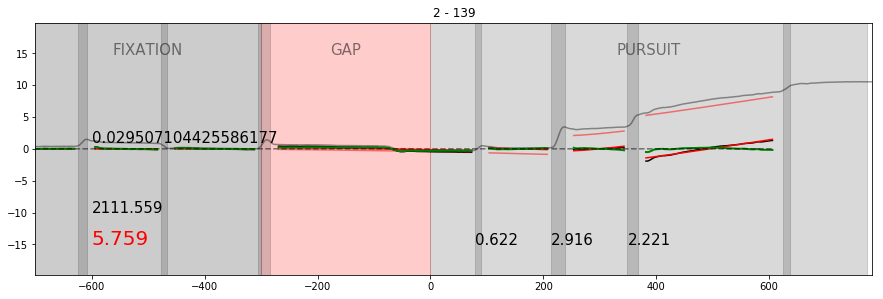

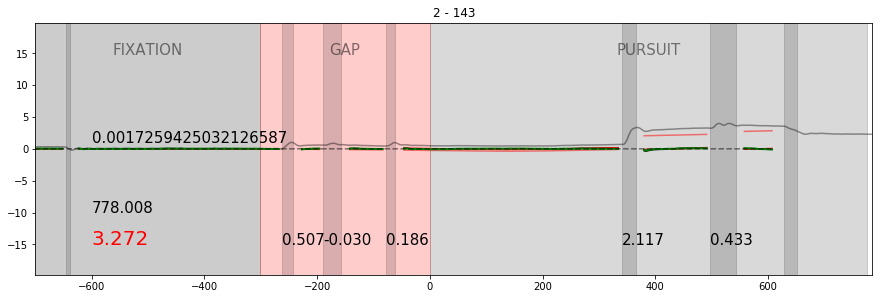

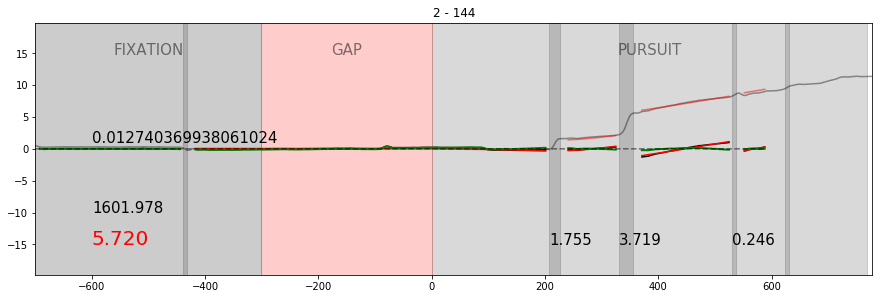

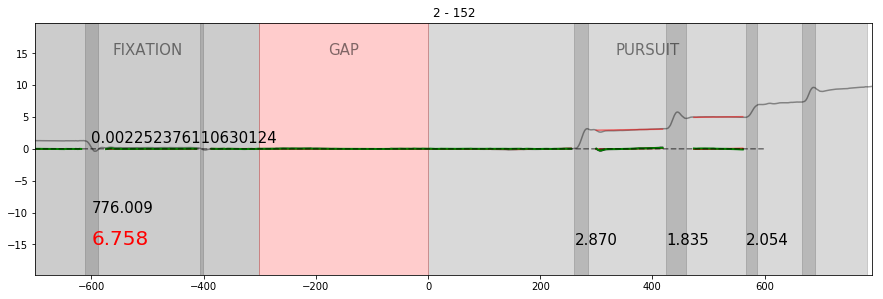

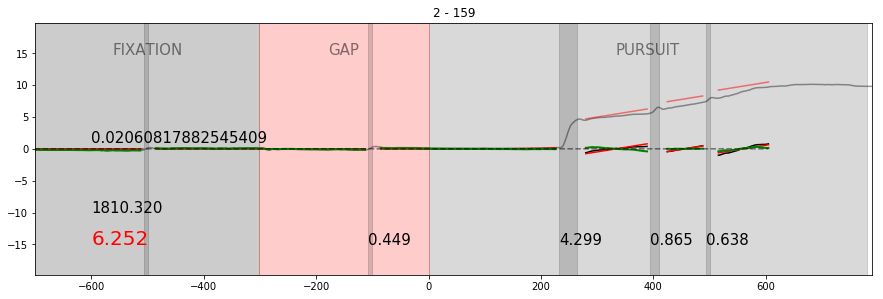

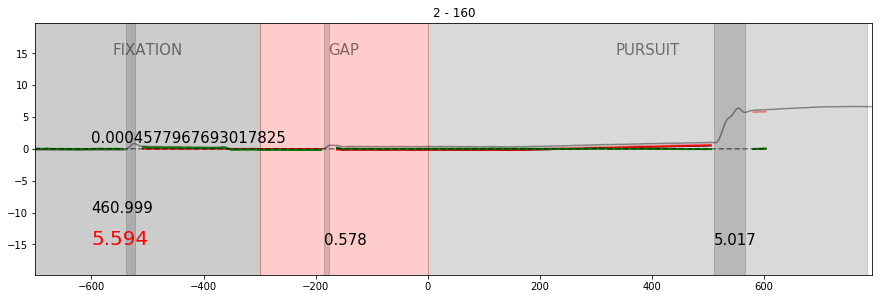

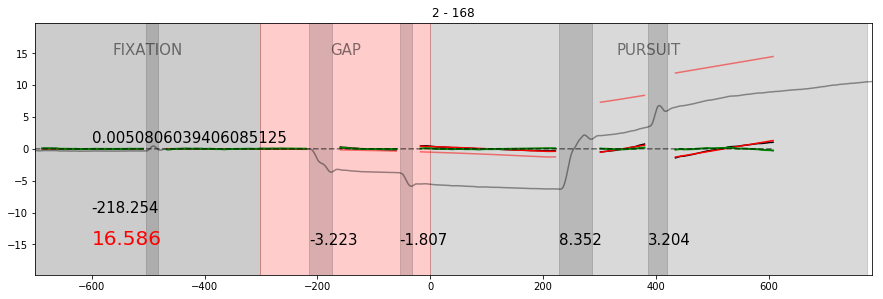

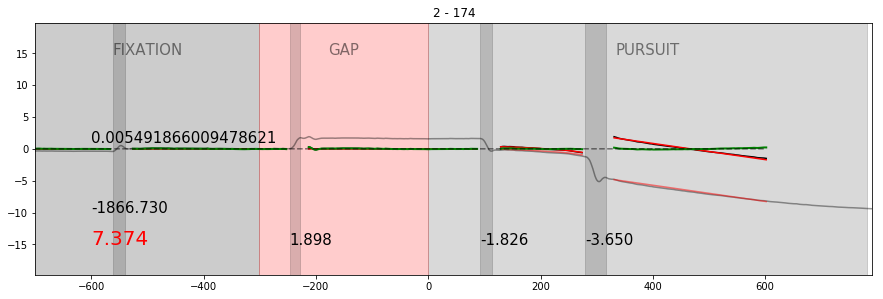

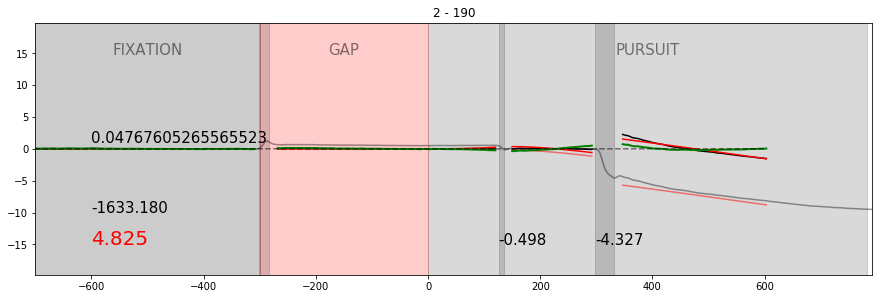

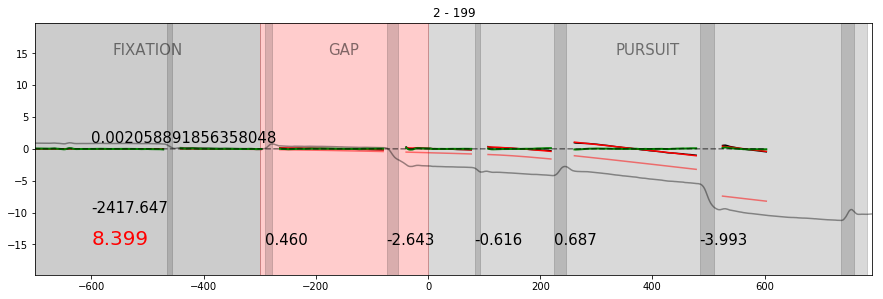

In [4]:
#for sujet in ['LB']:
for x in [7] : #range(len(sujet)) :
    print('sujet[x]', sujet[x])
    file = os.path.join('data', 'enregistrement_' + sujet[x] + '_' + time[x] + '.pkl')
    with open(file, 'rb') as fichier : param_exp = pickle.load(fichier, encoding='latin1')
    
    resultats = os.path.join('data', 'enregistrement_' + sujet[x] + '_' + time[x] + '.asc')
    data = read_edf(resultats, 'TRIALID')

    file = os.path.join('parametre/param_Fit_'+ sujet[x] +'_fct_velocity_2_step_False_whitening.pkl')
    with open(file, 'rb') as fichier : param_fit = pickle.load(fichier, encoding='latin1')
    #with open(file, 'rb') as fichier : param_fit1 = pickle.load(fichier, encoding='latin1')

    #file = os.path.join('parametre/param_Fit_'+ sujet[x] +'_fct_position_2_step_False_whitening.pkl')
    #with open(file, 'rb') as fichier : param_fit2 = pickle.load(fichier, encoding='latin1')

    
    A = ANEMO(param_exp)
    Plot = A.Plot(param_exp)
    
    N_trials, N_blocks = param_exp['N_trials'], param_exp['N_blocks']

    for block in range(3) :
        for trial in Bad_Fit[sujet[x]][block] :

            trial_data = trial + N_trials*block
            arg = A.arg(data[trial_data], trial=trial, block=block)

            fig, ax = Plot.plot_data(data, show='positon', trials=trial, block=block)

            onset = arg.TargetOn-arg.t_0
            xx = np.arange(len(arg.trackertime))

            #for param_fit, color in zip([param_fit2, param_fit1], ['r', 'b']):
            
            start_anti = int(param_fit['start_anti'][block][trial] + onset)
            a_anti = param_fit['a_anti'][block][trial]

            latency = int(param_fit['latency'][block][trial] + onset)
            tau = param_fit['tau'][block][trial]
            maxi = param_fit['maxi'][block][trial]
            after_sacc = 15
            before_sacc = 5
            
            
            sacc = np.zeros(len(arg.trackertime))
            i=0
            for s in range(len(arg.saccades)):
                sacc[i]   = arg.saccades[s][0] # onset sacc
                sacc[i+1] = arg.saccades[s][1] # end sacc
                sacc[i+2] = arg.saccades[s][2] # time sacc
                i = i+3                    

            fit = A.Equation.fct_position(xx, arg.data_x, sacc, len(arg.saccades),
                                          arg.dir_target, start_anti , a_anti,
                                          latency, tau, maxi, arg.t_0,
                                          arg.px_per_deg, before_sacc,
                                          after_sacc, do_whitening=False)

            color = 'r'
            
            
            fit = fit[:-280]
            time = arg.trackertime[:-280] -arg.TargetOn
            ax.plot(time, fit, c=color, alpha=0.5)
            
            d_x = A.data_deg(arg.data_x, arg.StimulusOf, arg.t_0, arg.saccades, before_sacc, after_sacc)
            d_x = d_x[:-280]
            
            d_x_2 = np.ma.masked_array(d_x[start_anti:], mask=np.isnan(fit[start_anti:])).compressed()
            # Méthode des trapèzes
            ax.text(-600, -10, '%0.3f'%(sp.trapz(d_x_2)), fontsize=15)
            
            for t in range(len(fit)):
                if np.isnan(fit[t]) : d_x[t]=np.nan

            larg_sacc = 0
            for s in range(len(arg.saccades)) :
                sacc = arg.saccades[s]
                
                start_sacc = int(sacc[0]-arg.t_0)-int(before_sacc)
                stop_sacc = int(sacc[1]-arg.t_0)+int(after_sacc)
                
                if stop_sacc+1 <= len(arg.data_x[:-280]) :
                    
                    if s < len(arg.saccades)-1 :
                        start_s2 = int(arg.saccades[s+1][0]-arg.t_0)-int(before_sacc)-1
                    
                        d_x[stop_sacc:] = d_x[stop_sacc:]-np.mean(d_x[stop_sacc:start_s2])
                        fit[stop_sacc:] = fit[stop_sacc:]-np.mean(fit[stop_sacc:start_s2])
                    else :
                        d_x[stop_sacc:] = d_x[stop_sacc:]-np.mean(d_x[stop_sacc:])
                        fit[stop_sacc:] = fit[stop_sacc:]-np.mean(fit[stop_sacc:])

                    if sacc[0] >= arg.StimulusOf :
                        larg_sacc = larg_sacc+abs((arg.data_x[stop_sacc]-arg.data_x[start_sacc-1])/arg.px_per_deg)
                        ax.text(sacc[0]-arg.TargetOn, -15,
                                '%0.3f'%((arg.data_x[stop_sacc]-arg.data_x[start_sacc-1])/arg.px_per_deg),
                                fontsize=15)
                    
                    
            
            ax.plot(time, d_x, 'k')
            ax.plot(time, fit, 'r')
            
            ax.plot(time, d_x-fit, 'green', lw=2)
            ax.plot(time, np.zeros(len(time)), '--k', alpha=.5)
            
            start, stop = start_anti, -1 #latency-200, latency+200
            d_x_ss_nan = np.ma.masked_array(d_x[start:stop], mask=np.isnan(fit[start:stop])).compressed()
            fit_ss_nan = np.ma.masked_array(fit[start:stop], mask=np.isnan(fit[start:stop])).compressed()
            
            #ax.text(-600, 11, np.nanmean(d_x_ss_nan-fit_ss_nan), fontsize=15)
            #ax.text(-600, 8, np.nanmean(abs(d_x_ss_nan-fit_ss_nan)), fontsize=15)
            ax.text(-600, 1, np.nanmean((d_x_ss_nan-fit_ss_nan)**2), fontsize=15)            
            #ax.text(-600, 2, np.corrcoef(d_x_ss_nan, fit_ss_nan)[0][1] , fontsize=15)
            

            ax.text(-600, -15, '%0.3f'%larg_sacc, fontsize=20, color='r')
            ax.set_xlabel('')
            ax.set_ylabel('')
            ax.set_title('%s - %s'%(block,trial))